In [1]:
# Basic Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# GroupKFold, perfect for this dataset
# For more information on this, check out this discussion by @AmbrosM https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/341070
from sklearn.model_selection import GroupKFold

# Imputation Imports
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import GridSearchCV

# Pipelining & preprocessing
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer

# Model used
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [2]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

In [3]:
# 데이터 모양 확인
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [4]:
print(f'Train data shape is {train.shape}')
print(f'Test data shape is {test.shape}')

Train data shape is (26570, 25)
Test data shape is (20775, 24)


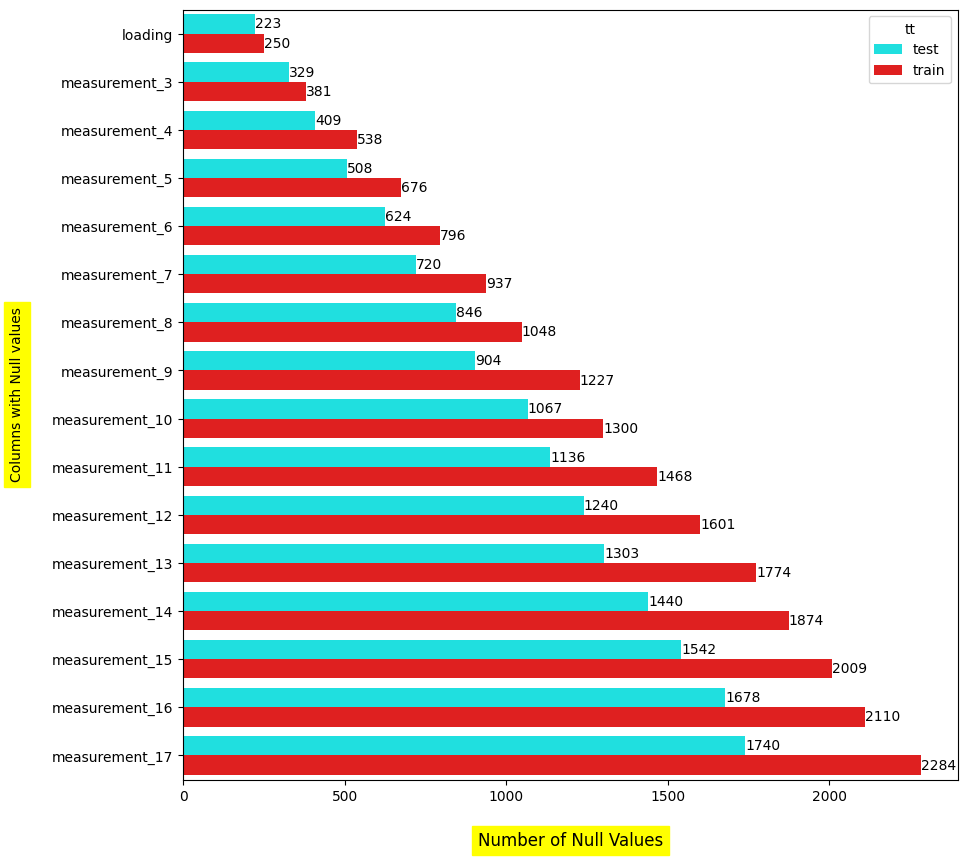

In [5]:
# 결측치
null = pd.concat([train.isna().sum(), test.isna().sum()], axis=0).rename("null_count").reset_index()
null["tt"] = ["train"]*len(train.columns) + ["test"]*len(test.columns)
null = null.sort_values('null_count',ascending = True)
null.drop(null.loc[null['null_count']==0].index,inplace = True)
plt.figure(figsize=(10,10))
ax = sns.barplot(data = null, y="index", x="null_count", hue="tt", orient="h",palette = ['cyan','red'])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_ylabel('Columns with Null values', backgroundcolor = 'yellow',labelpad = 20)
ax.set_xlabel('Number of Null Values', size = 'large',backgroundcolor = 'yellow',labelpad = 20)
plt.show()

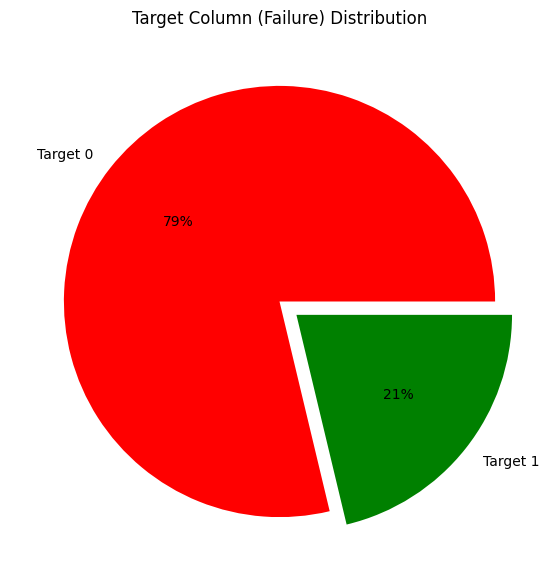

In [6]:
# 종속변수 분포 확인
data = [100*train['failure'].value_counts()[0]/len(train['failure']),100*train['failure'].value_counts()[1]/len(train['failure'])]
keys = [f'Target 0',f'Target 1']

plt.figure(figsize = (7,7))
plt.title('Target Column (Failure) Distribution')
ax = plt.pie(data,labels = keys,colors = ['red','green'],explode = [0,0.1],autopct='%.0f%%')
plt.show()

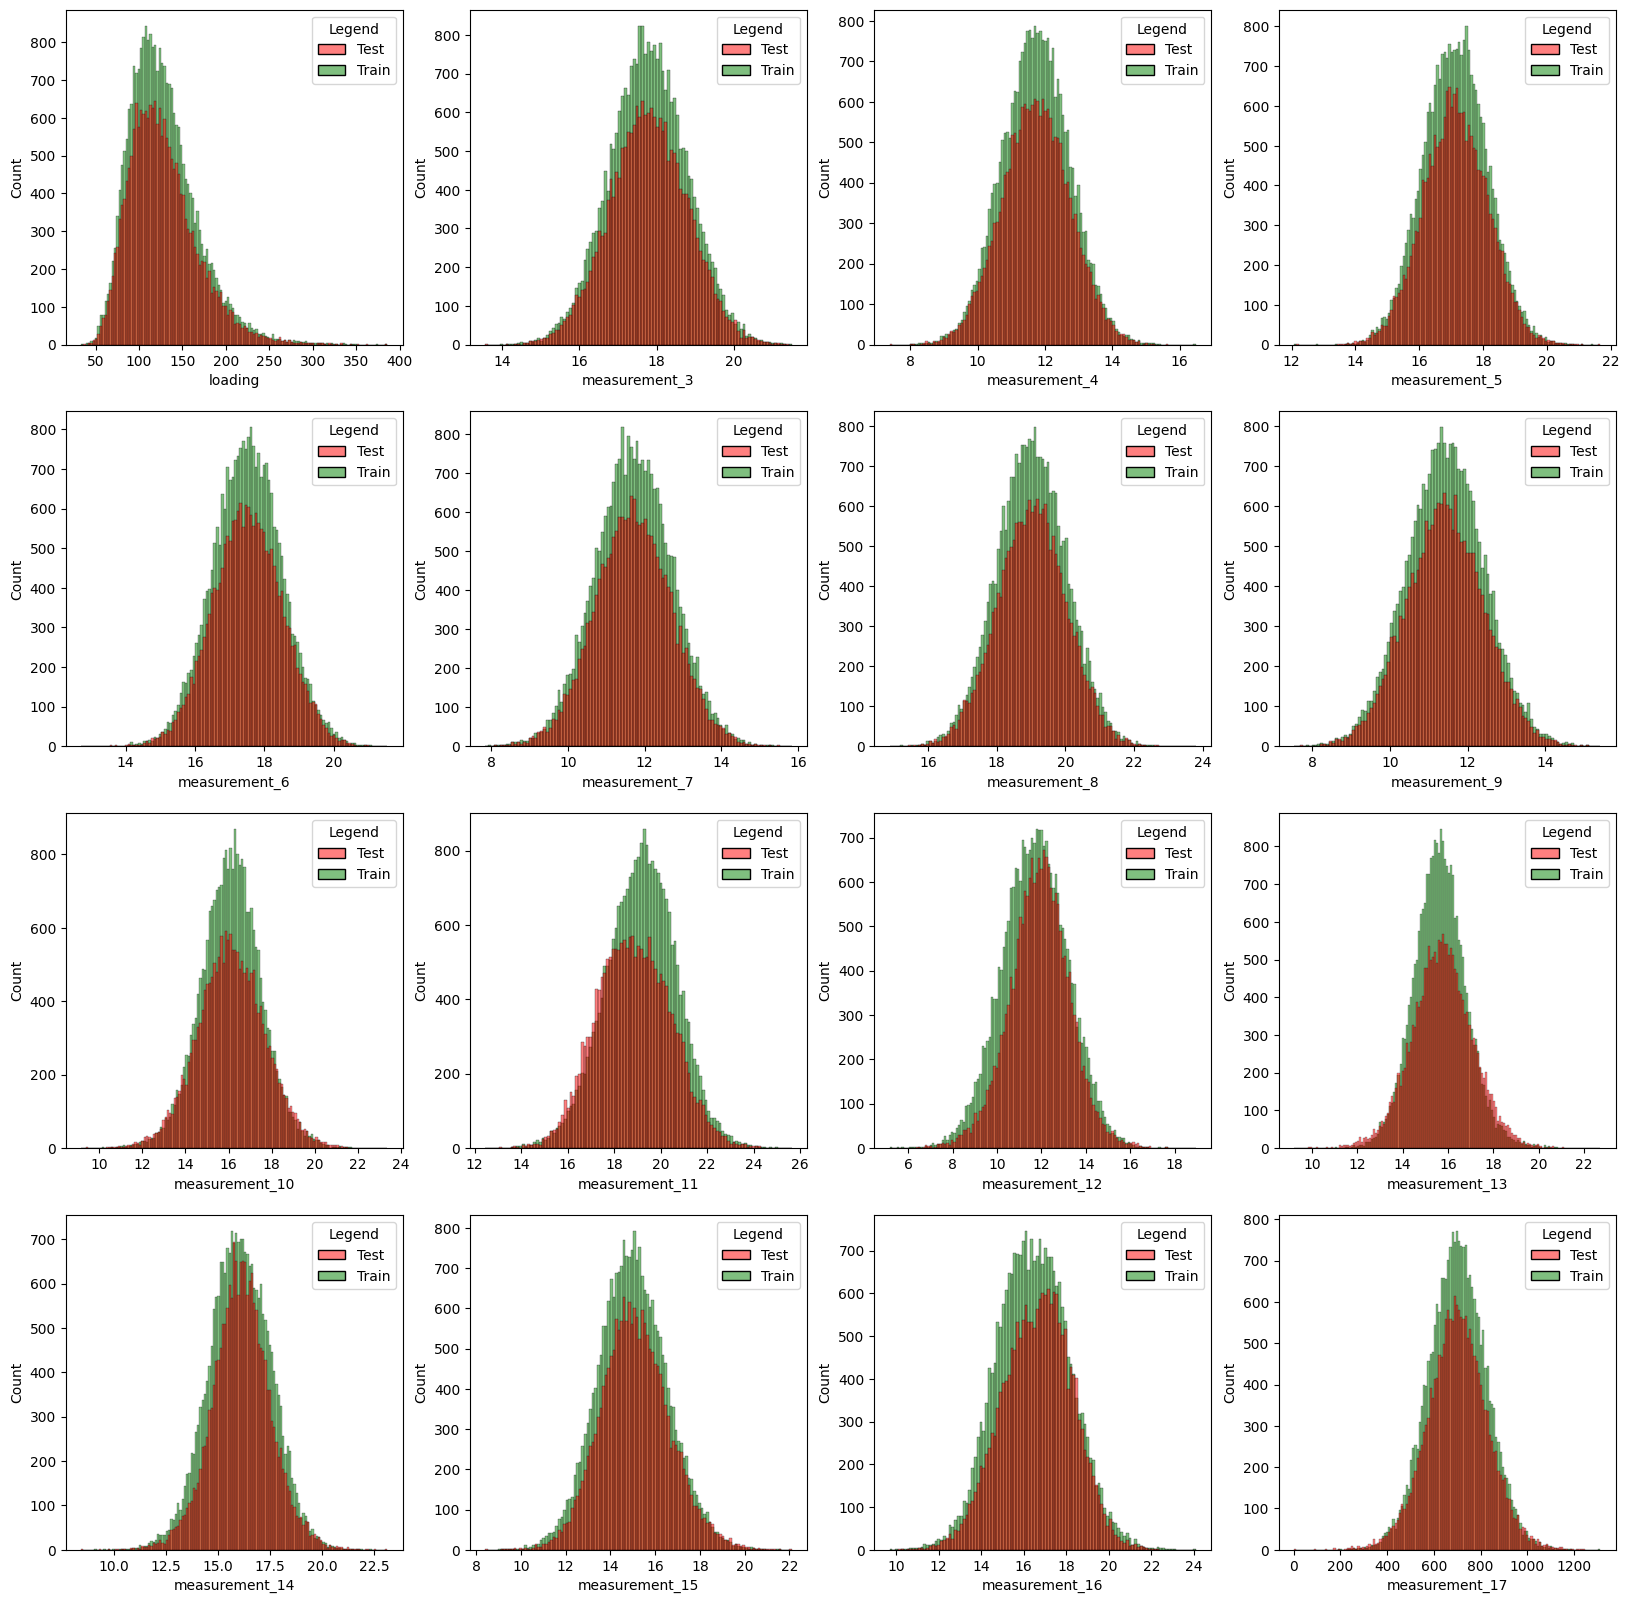

In [7]:
# 연속형 변수 분포
other_cols = ['product_code',"attribute_0", "attribute_1", "attribute_2", "attribute_3",'measurement_1','measurement_2','measurement_0']
numerical_cols   = [col for col in test.columns if col not in other_cols]

plt.figure(figsize=(20,20))
plt.title('Train and Test Distributions for the Continuous Float Columns')
df = train.copy()
df_test = test.copy()
df['Legend'] = 'Train'
df_test['Legend'] = 'Test'

i=1
for col in numerical_cols:
    plt.subplot(4,4,i)
    sns.histplot(data=pd.concat([df_test, df]), x=col, hue='Legend',palette = ['red','green'])
    i=i+1

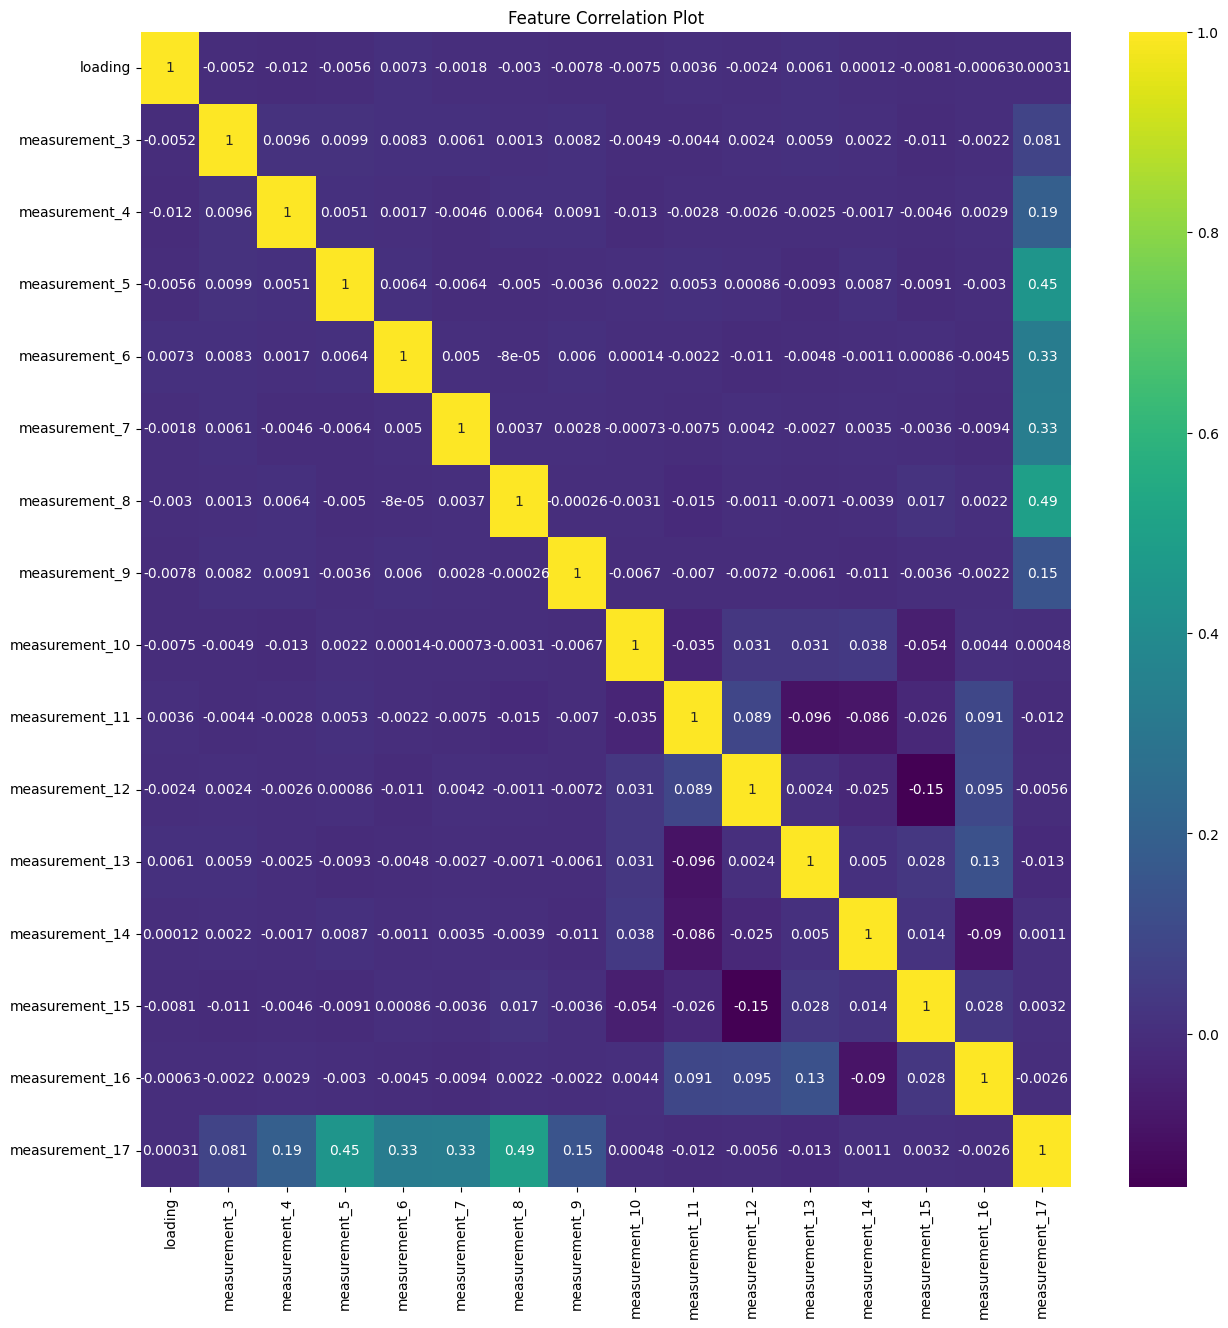

In [8]:
plt.figure(figsize = (15,15))
plt.title('Feature Correlation Plot')
sns.heatmap(df[numerical_cols].corr(), annot=True,cmap='viridis')
plt.show()

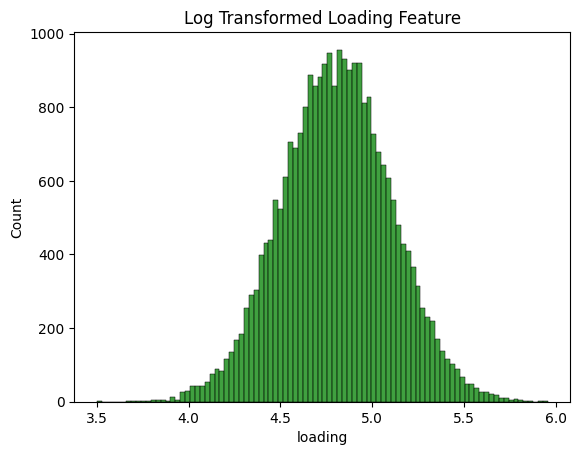

In [9]:
# 'loading' 비대칭하므로 log변환
plt.figure()
plt.title('Log Transformed Loading Feature')
ax = sns.histplot(np.log(train['loading']),color = ['green'])
plt.show()

In [10]:
# categorical columns
both = pd.concat([train,test])
both[['product_code','attribute_0','attribute_1','attribute_2', 'attribute_3']].drop_duplicates().set_index('product_code')

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


In [11]:
def explore_cat(col,col1,col2,explode1,explode2):
    data = [100*train[col].value_counts()[train[col].unique()[i]]/sum(train[col].value_counts()) for i in range(len(train[col].unique()))]
    keys = train[col].unique().tolist()

    data_test = [100*test[col].value_counts()[test[col].unique()[i]]/sum(test[col].value_counts()) for i in range(len(test[col].unique()))]
    keys_test = test[col].unique().tolist()

    plt.figure(figsize = (14,7))
    plt.subplot(1,2,1)
    plt.title(f'Train {col.capitalize()} Distribution')
    ax = plt.pie(data,labels = keys,colors = col1,explode =explode1,autopct='%.0f%%')
    plt.subplot(1,2,2)
    plt.title(f'Test {col.capitalize()} Distribution')
    ax = plt.pie(data_test,labels = keys_test,colors =col2,explode = explode2,autopct='%.0f%%')
    plt.show()

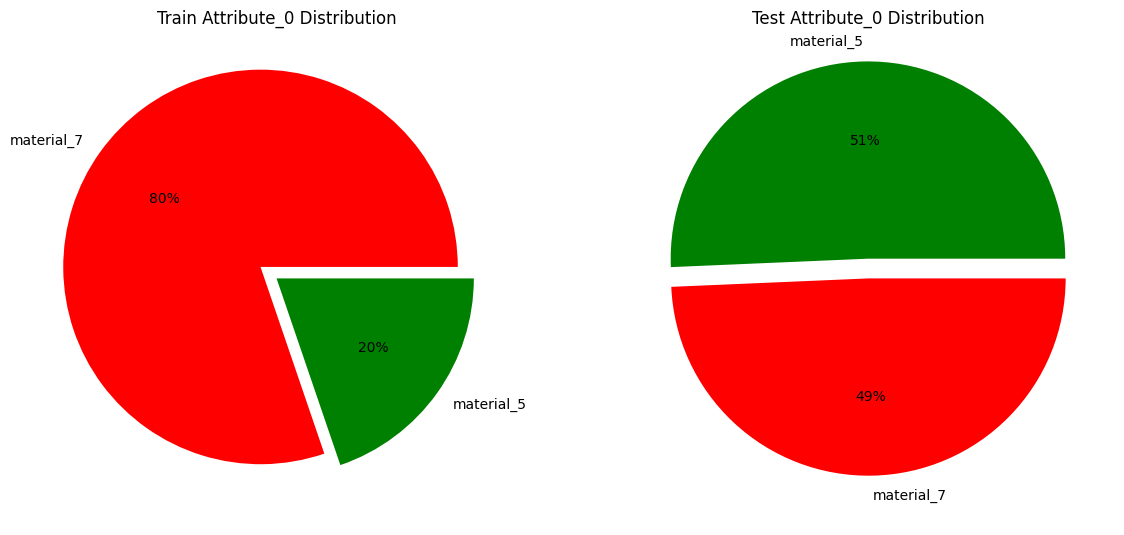

In [12]:
explore_cat('attribute_0',['red','green'],['green','red'],[0.1,0],[0.1,0])

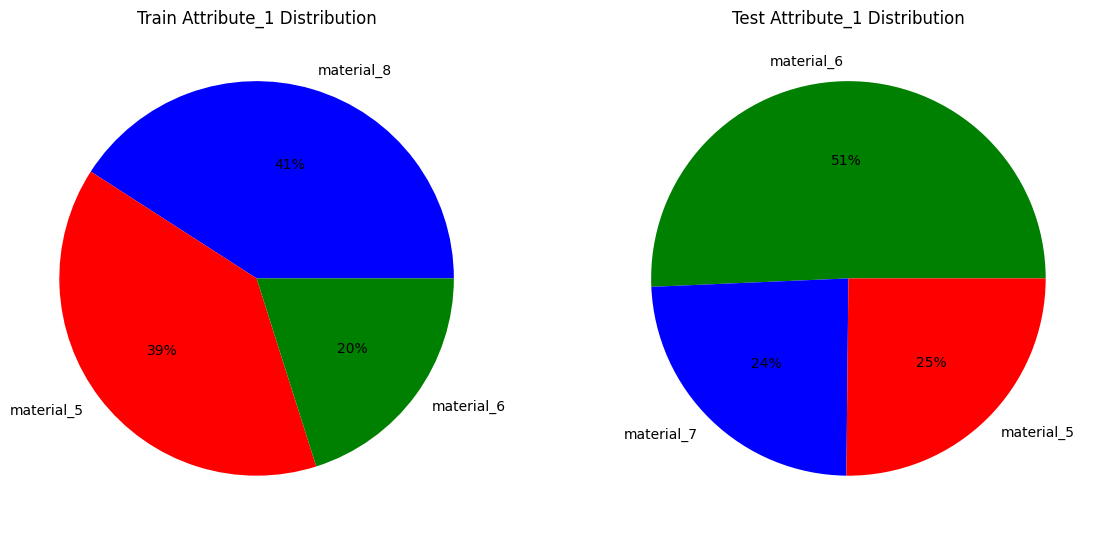

In [13]:
explore_cat('attribute_1',['blue','red','green'],['green','blue','red'],[0,0,0],[0,0,0])

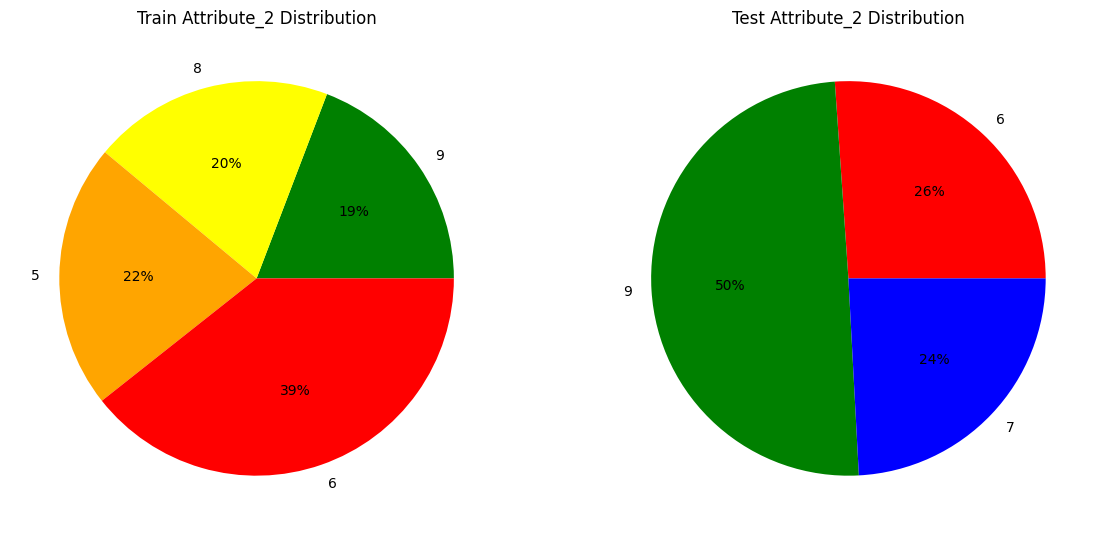

In [14]:
explore_cat('attribute_2',['green','yellow','orange','red'],['red','green','blue'],[0,0,0,0],[0,0,0])

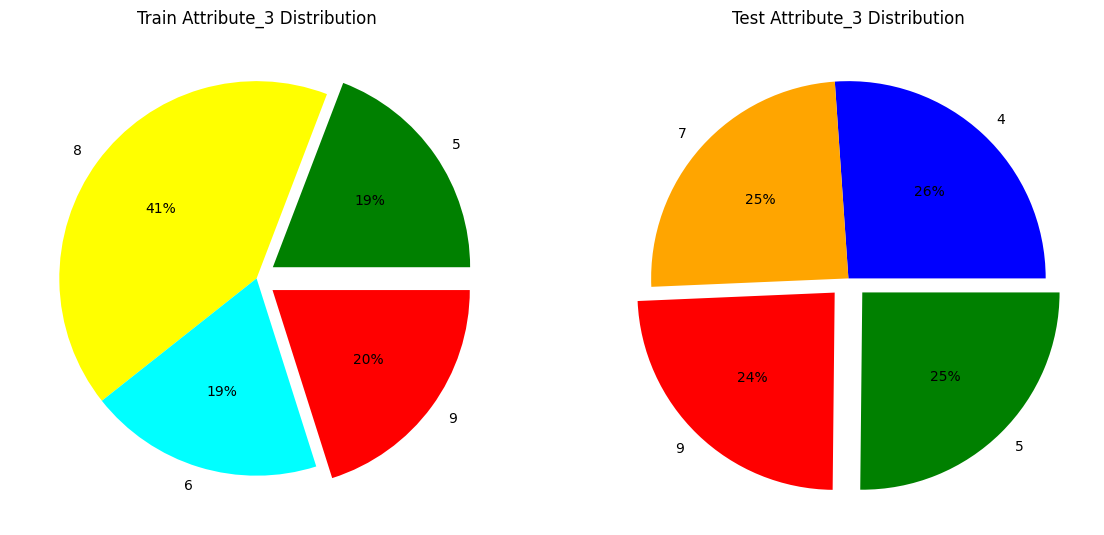

In [15]:
explore_cat('attribute_3',['green','yellow','cyan','red'],['blue','orange','red','green'],[0.1,0,0,0.1],[0,0,0.1,0.1])

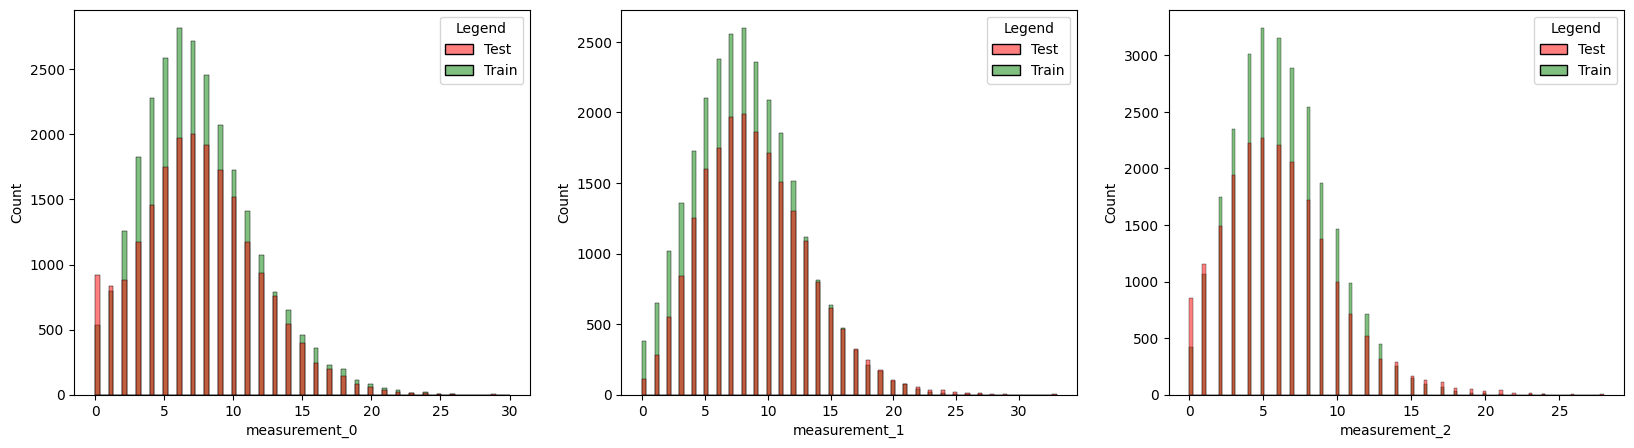

In [16]:
# categorical columns에 대한 Cardinality 분포
other_cols = ['measurement_0','measurement_1','measurement_2']

plt.figure(figsize=(20,5))
df = train.copy()
df_test = test.copy()
df['Legend'] = 'Train'
df_test['Legend'] = 'Test'

i=1
for col in other_cols:
    plt.subplot(1,3,i)
    sns.histplot(data=pd.concat([df_test, df]), x=col, hue='Legend',palette = ['red','green'])
    i=i+1

In [17]:
# categorical 변수 drop 
train.drop(["attribute_2", "attribute_3"],axis = 'columns',inplace=True)
test.drop(["attribute_2", "attribute_3"],axis = 'columns',inplace=True)

In [18]:
# 결측치 imputation (연관성 높은 변수 이용 LR)
impute_df = train.loc[(train['measurement_5'].isna() == False)&(train['measurement_6'].isna()==False)
          &(train['measurement_7'].isna() == False)&(train['measurement_8'].isna() == False)
          &(train['measurement_17'].isna() == False),
        ['measurement_5','measurement_6','measurement_7','measurement_8','measurement_17']]
impute_df_target = train.loc[(train['measurement_5'].isna() == False)&(train['measurement_6'].isna()==False)
          &(train['measurement_7'].isna() == False)&(train['measurement_8'].isna() == False)
          &(train['measurement_17'].isna() == True),
        ['measurement_5','measurement_6','measurement_7','measurement_8','measurement_17']]
impute_x = impute_df.drop('measurement_17',axis = 'columns')
impute_y = impute_df['measurement_17']
impute_model = LinearRegression()
impute_model.fit(impute_x,impute_y)
train.loc[impute_df_target.index,'measurement_17'] = impute_model.predict(impute_df_target.drop('measurement_17',axis = 'columns'))

In [19]:
# inspired by THE DEVESTATOR's notebook https://www.kaggle.com/code/thedevastator/tps-aug-simple-baseline
categorical_cols = ['product_code',"attribute_0", "attribute_1", "attribute_2", "attribute_3"]
numerical_cols   = [col for col in test.columns if col not in categorical_cols]
categorical_cols = ['attribute_0','attribute_1']


# Preprocessing for categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [20]:
x_train = train.sample(frac=0.8)
x_valid = train.drop(x_train.index)

y_train = x_train['failure']
y_valid = x_valid['failure']
x_train = x_train[test.columns]
x_valid = x_valid[test.columns]
x_test = test.copy()

print(len(x_train))
print(len(x_valid))
print(len(y_train))
print(len(y_valid))
print(len(x_test))

21256
5314
21256
5314
20775


In [21]:
x_train

,product_code,loading,attribute_0,attribute_1,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
13000,C,119.69,material_7,material_8,7,7,8,15.667,11.892,16.647,...,18.054,13.376,15.121,18.993,9.364,15.810,15.167,16.302,15.888,685.804000
24109,E,113.39,material_7,material_6,8,6,5,17.757,11.820,16.864,...,22.533,12.560,19.214,19.958,9.564,14.355,16.771,14.129,17.596,873.074000
11441,C,147.91,material_7,material_8,10,11,5,16.377,11.668,16.830,...,21.239,11.386,15.605,18.520,11.043,16.854,14.909,14.513,15.081,776.665472
13358,C,157.58,material_7,material_8,5,4,4,18.016,12.500,17.606,...,18.785,12.086,15.567,17.049,6.922,14.249,14.444,14.689,20.631,695.741000
5670,B,78.02,material_5,material_5,3,7,5,19.623,11.070,16.562,...,19.717,NaN,15.205,18.729,12.788,19.035,16.251,NaN,20.204,682.019000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12790,C,168.88,material_7,material_8,9,10,5,16.552,11.308,17.553,...,20.535,10.255,15.124,16.603,11.872,16.535,18.624,15.947,15.996,795.959000
12840,C,102.85,material_7,material_8,4,3,0,17.422,10.457,16.687,...,19.742,12.613,16.129,21.253,NaN,15.368,16.370,15.772,15.025,788.239000
14148,C,104.26,material_7,material_8,3,5,2,17.911,12.479,18.699,...,19.151,NaN,14.664,18.726,9.513,18.347,15.027,16.182,18.796,773.451000


In [22]:
# Log Transforming the slightly skewed feature and dropping roduct_code
for df in [x_train,x_valid,x_test]:
    df['loading'] = np.log(df['loading'])
    df.drop('product_code',axis = 'columns',inplace = True)

features = [f for f in x_train.columns if f != 'product_code']

In [24]:
model = make_pipeline(preprocessor, LogisticRegression(penalty='l1', random_state=1,solver = 'liblinear',C= 0.01,class_weight = 'balanced'))
model.fit(x_train[features], y_train)

preds_valid = model.predict_proba(x_valid[features])[:,1]
score = roc_auc_score(y_valid, preds_valid)
print(f"auc = {score:0.5f}")

auc = 0.59370


In [26]:
auc = []
test_pred = []
# GroupKFold
kf = GroupKFold(n_splits=5)
for fold, (idx_train, idx_valid) in enumerate(kf.split(train, train['failure'], train['product_code'])):
    xtrain = train.iloc[idx_train][test.columns]
    xvalid = train.iloc[idx_valid][test.columns]
    ytrain = train.iloc[idx_train]['failure']
    yvalid = train.iloc[idx_valid]['failure']
    xtest = test.copy()
    
    # Log Transforming the slightly skewed feature and dropping roduct_code
    for df in [xtrain,xvalid,xtest]:
        df['loading'] = np.log(df['loading'])
        df.drop('product_code',axis = 'columns',inplace = True)

    features = [f for f in xtrain.columns if f != 'product_code']
    # l1 penalty used because first simple model run revealed several low coeff features
    model = make_pipeline(preprocessor,LogisticRegression(penalty='l1', random_state=1,solver = 'liblinear',C= 0.01,class_weight = 'balanced'))
    model.fit(xtrain[features], ytrain)

    preds_valid = model.predict_proba(xvalid[features])[:,1]
    score = roc_auc_score(yvalid, preds_valid)
    print(f"Fold {fold}: auc = {score:0.5f}")
    auc.append(score)

    test_pred.append(model.predict_proba(xtest[features])[:,1])

print(f"Average auc = {sum(auc) / 5:.5f}")

Fold 0: auc = 0.58575
Fold 1: auc = 0.58221
Fold 2: auc = 0.59132
Fold 3: auc = 0.59582
Fold 4: auc = 0.59238
Average auc = 0.58950


In [ ]:
model = make_pipeline(
        preprocessor,
        XGBClassifier(n_estimators=1000, 
#                       random_state=2,
#                       n_jobs=-1,
                      max_depth=7,
                      learning_rate=0.02,
                      min_child_weight=1,
                      colsample_bytree=0.75, 
                      reg_alpha=0.03
                     )
    )
    
model.fit(x_train[features], y_train)

preds_valid = model.predict_proba(x_valid[features])[:,1]
score = roc_auc_score(y_valid, preds_valid)
print(f"auc = {score:0.5f}")

In [ ]:
model = make_pipeline(
        preprocessor,
        lgb.LGBMClassifier(num_leaves=100,
                      min_child_samples=5,
                      max_depth=5,
                      learning_rate=0.2,
                      reg_alpha=0)
    )
    
model.fit(x_train[features], y_train)

preds_valid = model.predict_proba(x_valid[features])[:,1]
score = roc_auc_score(y_valid, preds_valid)
print(f"auc = {score:0.5f}")

In [ ]:
model = make_pipeline(
        preprocessor,
    cb.CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True))

model.fit(x_train[features], y_train)

preds_valid = model.predict_proba(x_valid[features])[:,1]
score = roc_auc_score(y_valid, preds_valid)
print(f"auc = {score:0.5f}")

In [27]:
submission = pd.DataFrame({'id': test.index,
                           'failure': sum(test_pred)/5})
submission.to_csv('submission.csv', index=False)
submission

,id,failure
0,26570,0.487152
1,26571,0.444323
2,26572,0.468180
3,26573,0.470328
4,26574,0.635611
...,...,...
20770,47340,0.538295
20771,47341,0.374427
20772,47342,0.361604
20773,47343,0.518281
